In [1]:
%cd AtrialMFClass

/Users/vt/Library/CloudStorage/OneDrive-purdue.edu/Research/NODE_diffusion/fem/AtrialMFClass


In [2]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap, lax
from jax.config import config
from jax.scipy.special import expit as sigmoid
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from scipy.linalg import eigh


from jaxbo.mcmc_models import ReimannianMFGPclassifierFourier, ReimannianGPclassifierFourier
from jaxbo.input_priors import uniform_prior

from sklearn.metrics import balanced_accuracy_score

from utils.Mesh import Mesh
import meshio
onp.random.seed(1234)

In [3]:
with open('../PurdueP/Pmesh_ordered.txt','r') as f:
    st = f.read()

nodes_st, els_st = st.split('Elements')

nodes = list(map(lambda s: s.split(' '), nodes_st.split('\n')[2:-1]))
nodes = [[float(n[0]), float(n[1]), 0.0] for n in nodes]

els = list(map(lambda s: s.split(' '), els_st.split('\n')[2:-1]))
els = [[int(e) - 1 for e in el] for el in els]


m = Mesh(verts = nodes, connectivity = els)

In [4]:
print('Computing Laplacian')
K, M = m.computeLaplacian()
M *= 2 # bug in mass matrix
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

rng_key = random.PRNGKey(123)

n_eigs = m.verts.shape[0]

eigpairs = (np.array(eigvals[:n_eigs]), np.array(eigvecs[:,:n_eigs]).T)

D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, np.ones(D)*m.verts.shape[0])


options = {'kernel': 'RBF',
           'criterion': 'LW_CLSF',
           'input_prior': p_x,
           'kappa': 1.0,
           'nIter': 0}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 500,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = ReimannianGPclassifierFourier(options, eigpairs)

Computing Laplacian
Computing eigen values


In [8]:
length = 0.3
S = gp_model.eval_S(length, 1.0)
ws = random.normal(random.PRNGKey(0), shape = (n_eigs,31000))
f = np.dot(gp_model.eigenfunctions,ws*np.sqrt(S)[:,None])


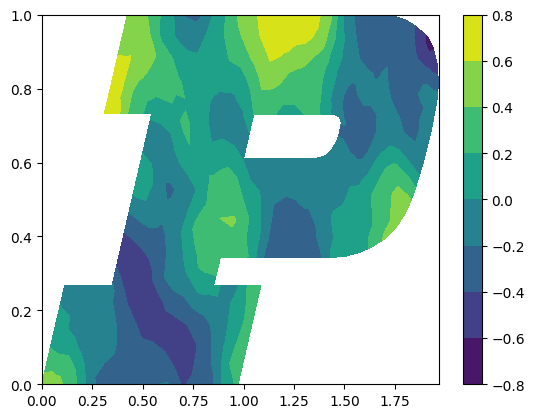

In [9]:
plt.tricontourf(m.verts[:,0], m.verts[:,1], m.connectivity, f[:,2])
#plt.triplot(m.verts[:,0], m.verts[:,1], m.connectivity)
plt.colorbar()

In [10]:
onp.savetxt('../PurdueP/PP_gfields.txt', f)